<a href="https://colab.research.google.com/github/shaistha24/recommendation_system/blob/main/collaborative_filtering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install surprise

In [ ]:
import numpy as np
import pandas as pd
import re #regex
import string
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from ast import literal_eval
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate


In [ ]:
anime = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/anime.csv")
rating = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/rating.csv")

In [ ]:
# Prepare data for collaborative filtering
def clean_data(anime, rating):

    # using only TV and Movie genre for simplicity
    anime = anime[(anime['type'] == 'TV') | (anime['type'] == 'Movie')]
    
    #remove unwanted symbols
    anime["name"] = anime["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))
    
    # Remove episodes with "Unknown" value
    anime[anime['episodes'] == "Unknown"]
    anime.episodes.replace({'Unknown':np.nan},inplace=True)

    # only select famous anime, 75% percentile
    m = anime['members'].quantile(0.75)
    anime = anime[(anime['members'] >= m)]

    #remove incomplete rows
    rating.loc[rating.rating == -1, 'rating'] = np.NaN

    # reset index
    anime.reset_index(drop=True,inplace=True)
    rating.reset_index(drop=True,inplace=True)
    
    return anime, rating

anime, rating = clean_data(anime, rating)
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


# Memory based techniques

## 1. User-based collaborative filtering

In [ ]:
# index
anime_index = pd.Series(anime.index, index=anime.name)

anime_rating = anime.merge(rating, how='inner', on='anime_id')

# Need only 3 columns
anime_rating_col = anime_rating[['user_id', 'name', 'rating_y']] 

# memory error, keeps crashing can use only 10000 users
anime_rating_col = anime_rating_col[(anime_rating_col['user_id'] <= 10000)]

# 2-D table for data summarization 
pivot = pd.pivot_table(anime_rating_col, index='user_id', columns='name', values='rating_y')

# Drop all users that never rate an anime 
# 0, or ‘index’ : Drop rows which contain missing values.
pivot.dropna(axis=0, how='all', inplace=True)

# Center the mean around 0 (centered cosine / pearson)
pivot_norm = pivot.apply(lambda x: x - np.nanmean(x), axis=1)

# fill NaN with 0
pivot_norm.fillna(0, inplace=True)

# similar user dataframe
similar_user_df = pd.DataFrame(cosine_similarity(pivot_norm, pivot_norm), index=pivot_norm.index, columns=pivot_norm.index)

In [ ]:
def similar_user(user_id):
    if user_id not in pivot_norm.index:
        return None, None
    else:
        similar_users = similar_user_df.sort_values(by=user_id, ascending=False).index[1:]
        score = similar_user_df.sort_values(by=user_id, ascending=False).loc[:, user_id].tolist()[1:]
        return similar_users, score

In [ ]:
users, score = similar_user(3)
for x,y in zip(users[:10], score[:10]):
    print("User {} with similarity of {}".format(x, y))

User 2986 with similarity of 0.3502463920298145
User 3681 with similarity of 0.3407187927372404
User 3028 with similarity of 0.33997937684120616
User 2411 with similarity of 0.33778981442850053
User 4481 with similarity of 0.3376927737260321
User 1966 with similarity of 0.3360271004231096
User 2038 with similarity of 0.32024694957147976
User 1606 with similarity of 0.3194861993583851
User 656 with similarity of 0.31929123836055745
User 3990 with similarity of 0.31705752479604915


In [ ]:
def user_recommendation(user_id, n_anime=10):
    users, scores = similar_user(user_id)
    
    # if empty 
    if users is None or scores is None:
        return None
    
    # taking top 10 users
    user_arr = np.array([x for x in users[:10]])
    sim_arr = np.array([x for x in scores[:10]])
    predicted_rating = np.array([])
    
    for anime_name in pivot_norm.columns:
        filtering = pivot_norm[anime_name].loc[user_arr] != 0.0  
        temp = np.dot(pivot[anime_name].loc[user_arr[filtering]], sim_arr[filtering]) / np.sum(sim_arr[filtering])
        predicted_rating = np.append(predicted_rating, temp)
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':pivot_norm.columns})
    filtering = (pivot_norm.loc[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend anime
    return anime.loc[anime_index.loc[temp.name[:n_anime]]]

In [ ]:
user_recommendation(3)

,anime_id,name,genre,type,episodes,rating,members
153,31964,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",TV,13,8.36,282002
60,22535,Kiseijuu Sei no Kakuritsu,"Action, Drama, Horror, Psychological, Sci-Fi, ...",TV,24,8.59,425457
741,3712,Zero no Tsukaima Princesses no Rondo,"Action, Adventure, Comedy, Ecchi, Fantasy, Har...",TV,12,7.60,210891
1101,11785,Haiyore Nyaruko san,"Comedy, Parody, Sci-Fi",TV,12,7.25,154595
91,30230,Diamond no Ace Second Season,"Comedy, School, Shounen, Sports",TV,51,8.50,38531
207,18689,Diamond no Ace,"Comedy, School, Shounen, Sports",TV,75,8.25,81384
745,20541,Mikakunin de Shinkoukei,"Comedy, Romance, School, Slice of Life",TV,12,7.59,133385
36,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562
26,457,Mushishi,"Adventure, Fantasy, Historical, Mystery, Seine...",TV,26,8.78,300030
16,24701,Mushishi Zoku Shou 2nd Season,"Adventure, Fantasy, Historical, Mystery, Seine...",TV,10,8.88,75894


In [ ]:
user_recommendation(5)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
189,3701,Kaiba,"Adventure, Mystery, Romance, Sci-Fi",TV,12,8.29,56927
36,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562
83,13125,Shinsekai yori,"Drama, Horror, Mystery, Sci-Fi, Supernatural",TV,25,8.53,288376
6,11061,Hunter x Hunter 2011,"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
104,523,Tonari no Totoro,"Adventure, Comedy, Supernatural",Movie,1,8.48,271484
5,32935,Haikyuu Karasuno Koukou VS Shiratorizawa Gakue...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
372,780,Detective Conan Movie 02 The Fourteenth Target,"Adventure, Comedy, Mystery, Police, Shounen",Movie,1,8.00,26284
322,387,Haibane Renmei,"Drama, Fantasy, Mystery, Psychological, Slice ...",TV,13,8.07,120731


## 2. Item-based collaborative filtering

In [ ]:
anime_rating = anime_rating[['user_id', 'name', 'rating_y']]
pivot = pd.pivot_table(anime_rating, index='name', columns='user_id', values='rating_y')

# 1, or ‘columns’ : Drop columns which contain missing value.
pivot.dropna(axis=1, how='all', inplace=True)

pivot_norm = pivot.apply(lambda x: x - np.nanmean(x), axis=1)

# fill NaN with 0
pivot_norm.fillna(0, inplace=True)

# similar item dataframe
similar_item_df = pd.DataFrame(cosine_similarity(pivot_norm, pivot_norm), index=pivot_norm.index, columns=pivot_norm.index)

In [ ]:
def similar_anime(anime_name):
    if anime_name not in pivot_norm.index:
        return None, None
    else:
        similar_animes = similar_item_df.sort_values(by=anime_name, ascending=False).index[1:]
        score = similar_item_df.sort_values(by=anime_name, ascending=False).loc[:, anime_name].tolist()[1:]
        return similar_animes, score

In [ ]:
similar_animes, score = similar_anime('Naruto')

In [ ]:
similar_animes

Index(['Bleach',
       'Naruto Movie 1 Dai Katsugeki Yuki Hime Shinobu Houjou Dattebayo ',
       'Naruto Shippuuden Movie 1',
       'Naruto Movie 2 Dai Gekitotsu Maboroshi no Chiteiiseki Dattebayo ',
       'Naruto Movie 3 Dai Koufun Mikazuki Jima no Animaru Panikku Dattebayo ',
       'Naruto Shippuuden Movie 2 Kizuna',
       'Naruto Shippuuden Movie 3 Hi no Ishi wo Tsugu Mono', 'Dragon Ball Z',
       'Sword Art Online', 'Fairy Tail',
       ...
       'Kaiba', 'Girls und Panzer der Film', 'Yojouhan Shinwa Taikei',
       'Kizumonogatari II Nekketsu hen', 'Memories', 'Bananya', 'Orange Mirai',
       'Sennen Joyuu', 'Endride', 'Texhnolyze'],
      dtype='object', name='name', length=1484)

In [ ]:

# predict the rating of anime A by other users 
def predict_rating(user_id, anime_name, max_neighbor=10):
    animes, scores = similar_anime(anime_name)
    anime_arr = np.array([x for x in animes])
    sim_arr = np.array([x for x in scores])
    
    # anime already rated by user x
    filtering = pivot_norm[user_id].loc[anime_arr] != 0
    
    # calculate the predicted score
    s = np.dot(sim_arr[filtering][:max_neighbor], pivot[user_id].loc[anime_arr[filtering][:max_neighbor]]) \
            / np.sum(sim_arr[filtering][:max_neighbor])
    
    return s

In [ ]:
predict_rating(3, "Steins Gate")

9.0511507264121

In [ ]:
predict_rating(3, "Cowboy Bebop")

8.645364065411727

In [ ]:
# recommend top 10 anime for user A 
def item_recommendation(user_id, n_anime=10):
    predicted_rating = np.array([])
    
    for _anime in pivot_norm.index:
        predicted_rating = np.append(predicted_rating, predict_rating(user_id, _anime))
    
    # don't recommend something that user has already rated
    temp = pd.DataFrame({'predicted':predicted_rating, 'name':pivot_norm.index})
    filtering = (pivot_norm[user_id] == 0.0)
    temp = temp.loc[filtering.values].sort_values(by='predicted', ascending=False)

    # recommend anime 
    return anime.loc[anime_index.loc[temp.name[:n_anime]]]

In [ ]:
item_recommendation(3)
#Compared to the user based collaborative filtering, the recommendation given is different.
#As we know, in the user based, so many user did not rate the anime. In the item based however, 
#I think it is more robust because there is no anime that never rated by users.

,anime_id,name,genre,type,episodes,rating,members
30,5258,Hajime no Ippo New Challenger,"Comedy, Drama, Shounen, Sports",TV,26,8.75,88995
6,11061,Hunter x Hunter 2011,"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
41,19647,Hajime no Ippo Rising,"Comedy, Drama, Shounen, Sports",TV,25,8.68,66756
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
98,7655,Major S6,"Comedy, Drama, Sports",TV,25,8.49,24788
11,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376
19,263,Hajime no Ippo,"Comedy, Drama, Shounen, Sports",TV,75,8.83,157670
37,12365,Bakuman 3rd Season,"Comedy, Drama, Romance, Shounen",TV,25,8.71,133620
303,2159,Ookiku Furikabutte,"Comedy, Sports",TV,25,8.11,49599
124,627,Major S1,"Comedy, Drama, Shounen, Sports",TV,26,8.42,41061


# Model based techniques

## SVD

In [ ]:
anime1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/anime.csv")
rating1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/rating.csv")
# using only TV and Movie genre for simplicity
#anime1 = anime1[(anime1['type'] == 'TV') | (anime1['type'] == 'Movie')]
    
#remove unwanted symbols
anime1["name"] = anime1["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

#remove incomplete rows
rating1.loc[rating1.rating == -1, 'rating'] = np.NaN
rating1.fillna(0, inplace=True)
rating1.reset_index(drop=True,inplace=True)

#anime1, rating1 = clean_data(anime1, rating1)
anime_rating_svd=pd.merge(anime1,rating1,on='anime_id')
anime_rating_svd.head()

In [ ]:
anime_rating_svd.rename(columns={'rating_x':'avg_rating','rating_y':'user_rating'},inplace=True)
anime_rating_svd.head()

In [ ]:
anime_rating_svd.shape

In [ ]:
anime_rating_svd.duplicated(subset=['user_id','name']).sum()
anime_rating1=anime_rating_svd.copy()
anime_rating1.drop_duplicates(subset=['user_id','name'],inplace=True)
anime_rating1.reset_index(drop=True,inplace=True)
anime_rating1

In [ ]:
counts = anime_rating1['user_id'].value_counts()
anime_feature = anime_rating1[anime_rating1['user_id'].isin(counts[counts >= 1000].index)]
anime_feature

In [ ]:
anime_feature.shape

(320421, 9)

In [ ]:
anime_feature.user_rating.value_counts()

0.0     73071
7.0     64067
8.0     57021
6.0     41355
9.0     28687
5.0     22611
10.0    17665
4.0      8543
3.0      3909
2.0      1997
1.0      1495
Name: user_rating, dtype: int64

0.0     73071
7.0     64067
8.0     57021
6.0     41355
9.0     28687
5.0     22611
10.0    17665
4.0      8543
3.0      3909
2.0      1997
1.0      1495
Name: user_rating, dtype: int64

In [ ]:
reader = Reader(rating_scale=(1.0,10.0))
data1 = Dataset.load_from_df(anime_feature[['user_id', 'name', 'user_rating']], reader)

algo = SVD()
cross_validate(algo, data1, measures=['rmse'], cv=3, return_train_measures=True, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8708  1.8687  1.8775  1.8723  0.0037  
RMSE (trainset)   0.7256  0.7294  0.7276  0.7275  0.0016  
Fit time          14.34   14.61   14.49   14.48   0.11    
Test time         1.34    1.10    1.14    1.20    0.10    


{'fit_time': (14.336825609207153, 14.606786012649536, 14.494605779647827),
 'test_rmse': array([1.87079308, 1.86865296, 1.87745248]),
 'test_time': (1.3384196758270264, 1.1046507358551025, 1.1437671184539795),
 'train_rmse': array([0.72555117, 0.72937124, 0.72763161])}

In [ ]:

trainset = data1.build_full_trainset()
algo.fit(trainset)


In [ ]:
items = anime_feature['name'].unique()
testset = [[13645, iid, 8] for iid in items]
#predictions = svd.test(test)
predictions = algo.fit(trainset).test(testset)
pred = pd.DataFrame(predictions)

In [ ]:
pred.sort_values(by='est', ascending=False).head(10)
# predicted rating that a user may give for the respective animes.

,uid,iid,r_ui,est,details
0,13645,Kimi no Na wa,8,7.591546,{'was_impossible': False}
39,13645,Death Note,8,7.177585,{'was_impossible': False}
29,13645,Tengen Toppa Gurren Lagann,8,7.105428,{'was_impossible': False}
319,13645,Black Lagoon,8,7.095684,{'was_impossible': False}
3,13645,Steins Gate,8,7.092327,{'was_impossible': False}
48,13645,Boku dake ga Inai Machi,8,7.080105,{'was_impossible': False}
7,13645,Ginga Eiyuu Densetsu,8,7.070995,{'was_impossible': False}
6,13645,Hunter x Hunter 2011,8,7.038348,{'was_impossible': False}
1,13645,Fullmetal Alchemist Brotherhood,8,7.029501,{'was_impossible': False}
64,13645,Hellsing Ultimate,8,7.019207,{'was_impossible': False}


## Clustering

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

In [ ]:
anime2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/anime.csv")
rating2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/anime_dataset/rating.csv")
user_rating = rating2.copy()
user_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
user_rating.shape


(7813737, 3)

In [ ]:
# Calculate mean rating per user
mean_rating = user_rating.groupby(['user_id']).mean().reset_index()
mean_rating['mean_rating'] = mean_rating['rating']
mean_rating.drop(['anime_id','rating'],axis=1, inplace=True)

In [ ]:
mean_rating.head(5)

,user_id,mean_rating
0,1,-0.712418
1,2,2.666667
2,3,7.382979
3,4,-1.000000
4,5,4.263383


In [ ]:
user_rating = pd.merge(user_rating,mean_rating,on=['user_id','user_id'])

In [ ]:
user_rating.head(5)

,user_id,anime_id,rating,mean_rating
0,1,20,-1,-0.712418
1,1,24,-1,-0.712418
2,1,79,-1,-0.712418
3,1,226,-1,-0.712418
4,1,241,-1,-0.712418


In [ ]:
user_rating = user_rating.drop(user_rating[user_rating.rating < user_rating.mean_rating].index)

# 4 anime were rated by user 1 after removing anything below mean value
user_rating[user_rating['user_id']== 1].head(10)

,user_id,anime_id,rating,mean_rating
47,1,8074,10,-0.712418
81,1,11617,10,-0.712418
83,1,11757,10,-0.712418
101,1,15451,10,-0.712418


In [ ]:
user_rating.shape

(4262566, 4)

In [ ]:
user_rating["user_id"].unique()
user_rating = user_rating.rename({'rating':'userRating'}, axis='columns')

In [ ]:
# merge both anime2 and user_rating 
merged_user_rating = pd.merge(anime2,user_rating,on=['anime_id','anime_id'])
merged_user_rating= merged_user_rating[merged_user_rating.user_id <= 30000]  # session crashes so lets use 30000 only
merged_user_rating.head(5)



,anime_id,name,genre,type,episodes,rating,members,user_id,userRating,mean_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,7.699301
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10,8.729242
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10,7.372287
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10,8.356322
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10,-0.832298


In [ ]:
len(merged_user_rating['anime_id'].unique())

8243

In [ ]:
len(anime2['anime_id'].unique())

12294

In [ ]:
user_anime = pd.crosstab(merged_user_rating['user_id'], merged_user_rating['name'])
user_anime.head(10)

name,&quot;0&quot;,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,...,Zoids Fuzors,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Koihime,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zonmi-chan: Halloween☆Special Movie!,Zonmi-chan: Meat Pie of the Dead,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver the Movie Specials,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,fake!fake!,gdgd Fairies,gdgd Fairies 2,gdgd Fairies 2 Episode 0,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_anime.shape

(30000, 8243)

In [ ]:
# Principal Component Analysis creates new set of  linear combination of the original set of variables
# Reducing dimension of data for clustering and visualize

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_anime) # user_anime is the rescaled data
reduced_sample = pca.transform(user_anime) 

In [ ]:
reduced_sample = pd.DataFrame(reduced_sample)
reduced_sample.head()

,0,1,2
0,-1.723255,0.554176,0.337499
1,-1.903027,0.312957,0.085377
2,-0.089619,1.244718,-1.234174
3,-0.023707,0.508048,0.519471
4,3.454853,0.541645,-1.039901


In [ ]:
tocluster = pd.DataFrame(reduced_sample[[0,1,2]])

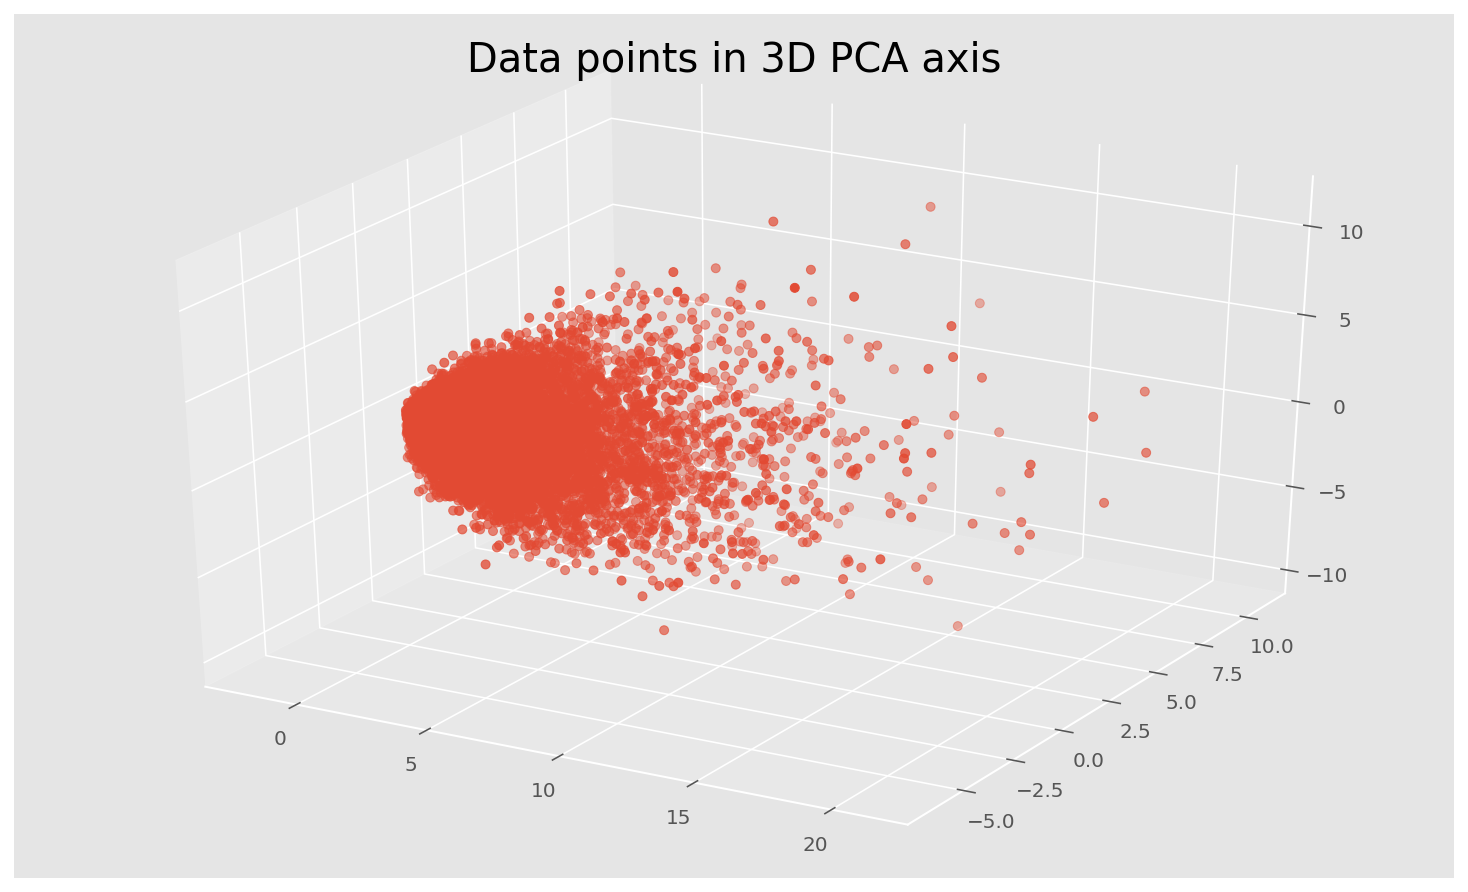

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

In [ ]:
#Selecting number of k
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

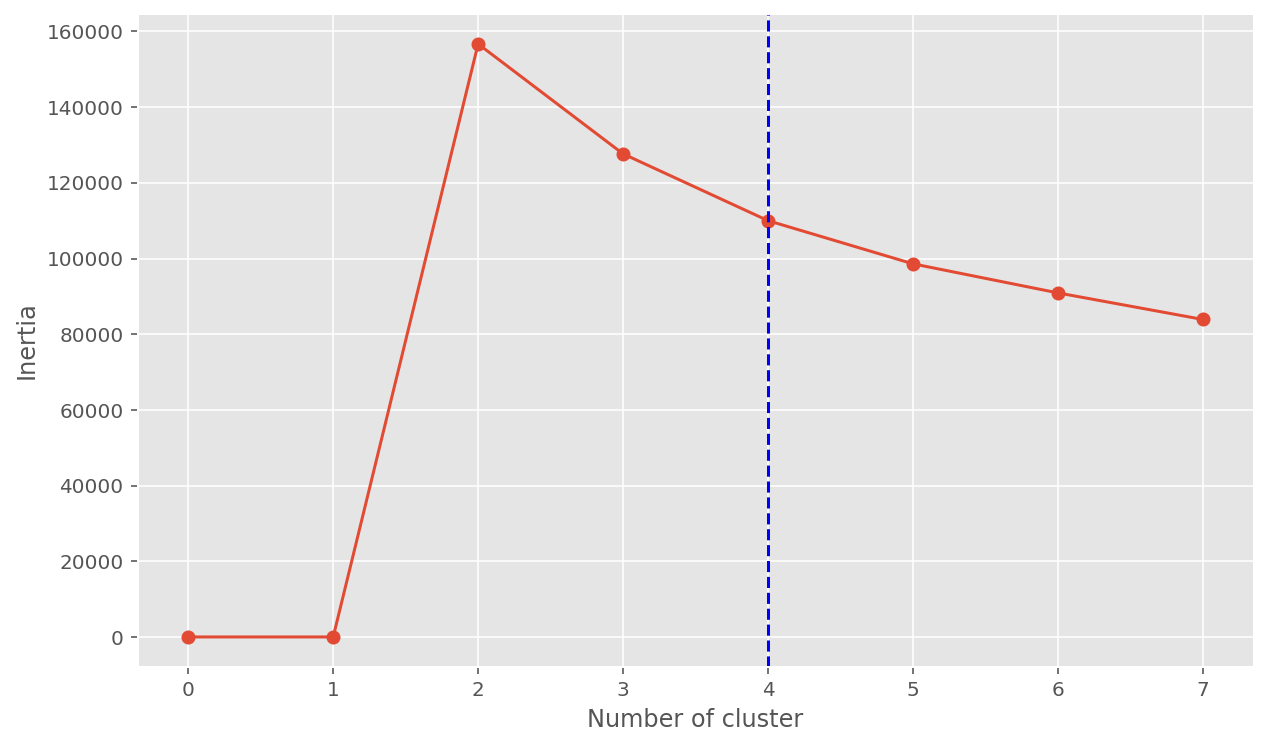

In [ ]:
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

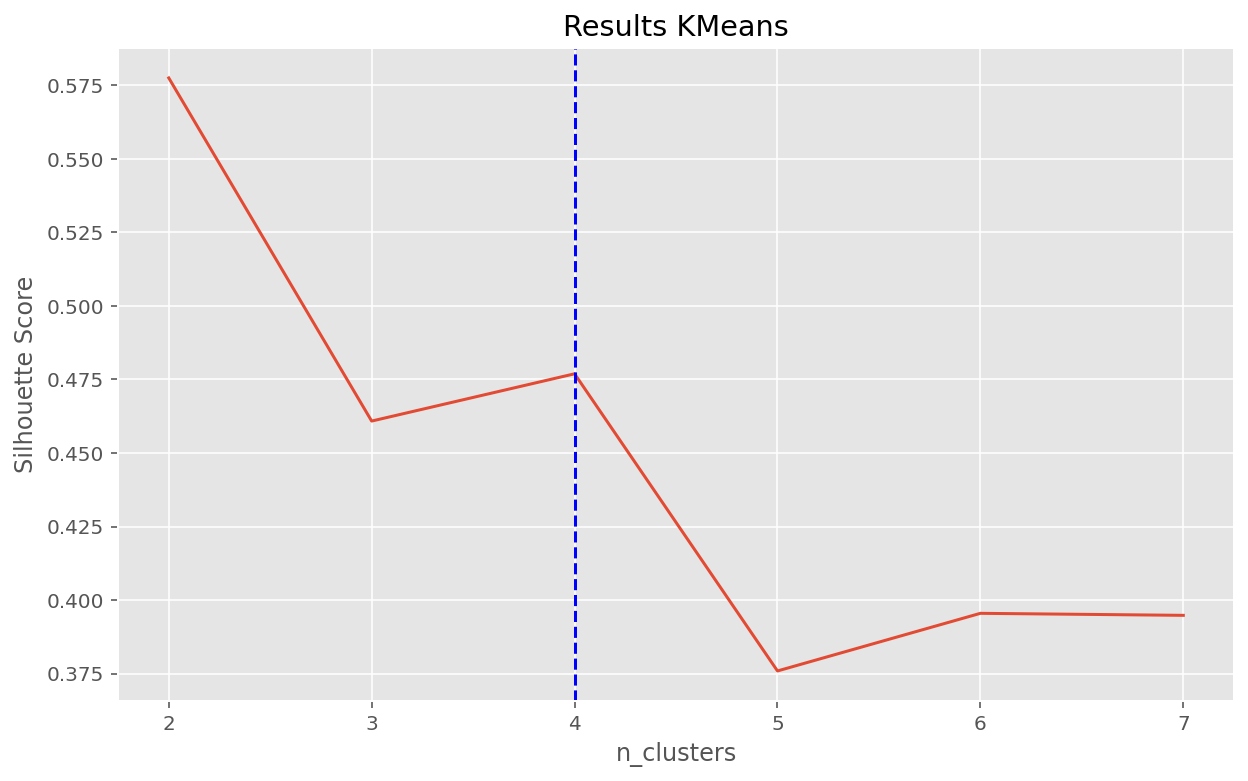

In [ ]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

In [ ]:
#K means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[-1.12627866 -0.10740575  0.07312706]
 [ 2.44555921 -1.19602272 -0.6612068 ]
 [ 1.40009261  1.79588425 -0.01006964]
 [ 8.02600876 -0.4676218   1.12944713]]


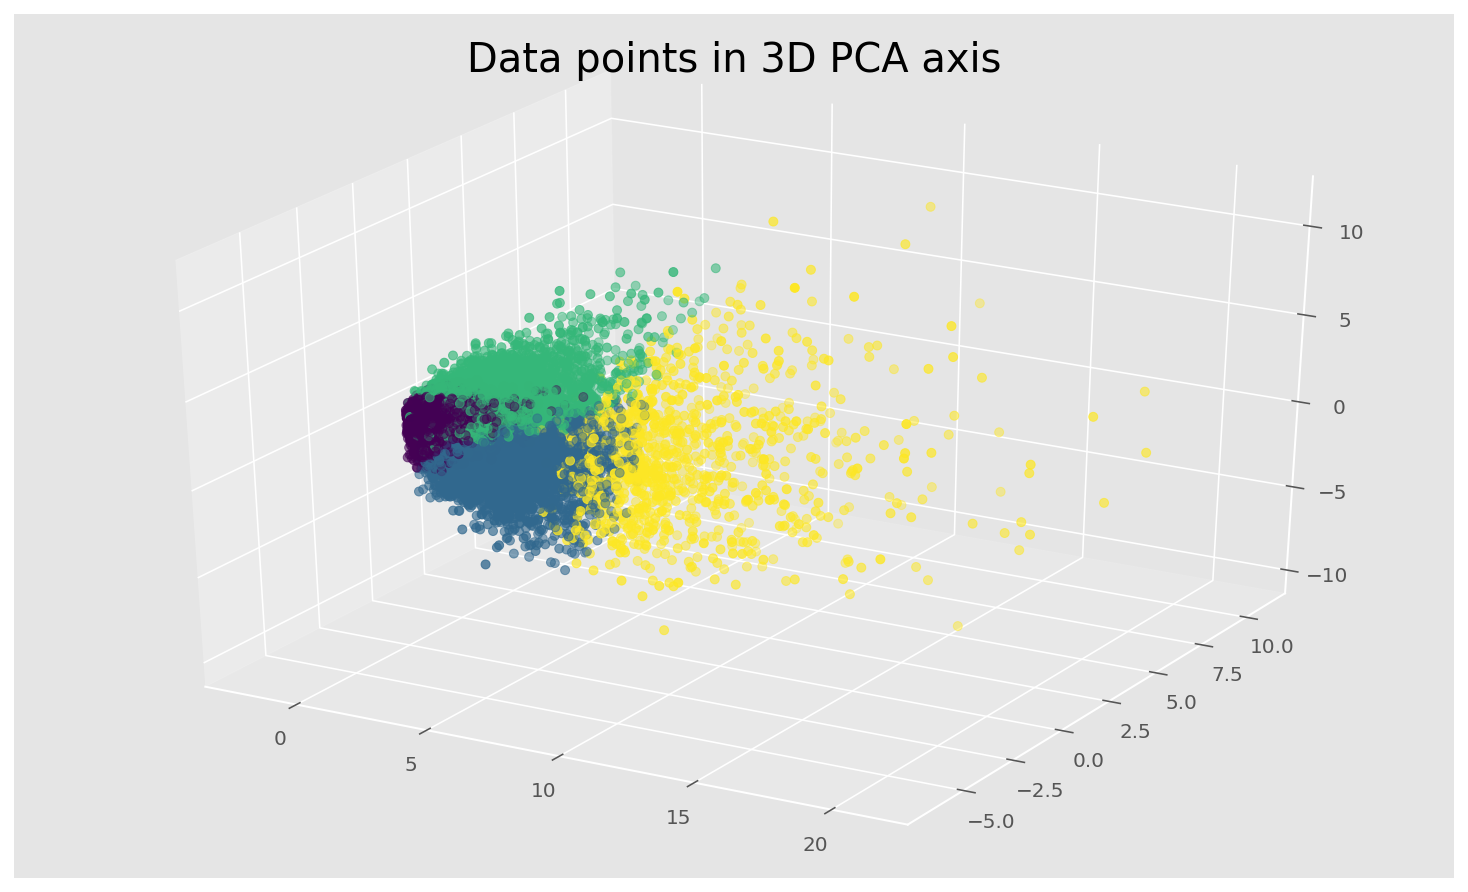

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

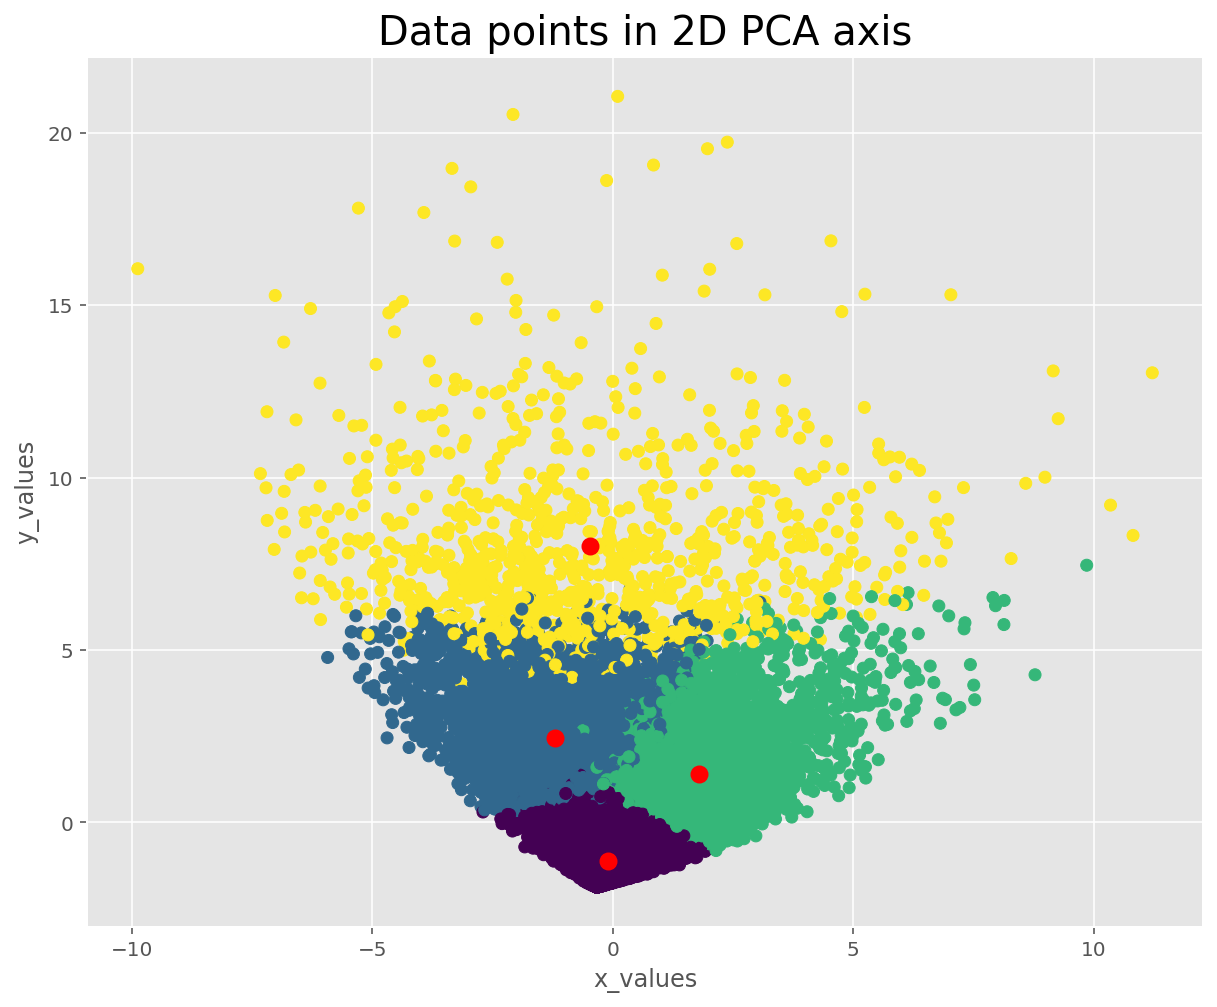

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

In [ ]:
user_anime['cluster'] = c_preds
user_anime.head(10)

name,&quot;0&quot;,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,009-1: R&amp;B,00:08,07-Ghost,1+2=Paradise,100%,100-man-nen Chikyuu no Tabi: Bander Book,1000-nen Joou: Queen Millennia,1001 Nights,11-nin Iru!,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-sai.,12-sai. 2nd Season,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,1989,20-dai no Heya-hen,...,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Koihime,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zonmi-chan: Halloween☆Special Movie!,Zonmi-chan: Meat Pie of the Dead,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,_Summer Specials,eX-Driver,eX-Driver the Movie,eX-Driver the Movie Specials,eX-Driver: Nina &amp; Rei Danger Zone,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,fake!fake!,gdgd Fairies,gdgd Fairies 2,gdgd Fairies 2 Episode 0,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Columns: 7853 entries, &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi to cluster
dtypes: int32(1), int64(7852)
memory usage: 1.2 GB


In [ ]:
#Characteristic of each cluster
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()

In [ ]:
#Top 15 anime which will explain characteristic of this cluster
c0.sort_values(ascending=False)[0:15]

name
Death Note                            0.322281
Shingeki no Kyojin                    0.199464
Fullmetal Alchemist: Brotherhood      0.186020
Code Geass: Hangyaku no Lelouch       0.181235
Sword Art Online                      0.181140
Angel Beats!                          0.168700
Sen to Chihiro no Kamikakushi         0.160088
Code Geass: Hangyaku no Lelouch R2    0.155686
Fullmetal Alchemist                   0.153342
Elfen Lied                            0.147553
Naruto                                0.147457
Ouran Koukou Host Club                0.136548
Toradora!                             0.126023
Mirai Nikki (TV)                      0.117937
Clannad                               0.117937
dtype: float64

In [ ]:
def createList(animelist):
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime2['name']:
        if x in animelist:
            episode_list.append(anime2[anime2['name']==x].episodes.values.astype(int))
            member_list.append(anime2[anime2['name']==x].members.values.astype(int))
            rating_list.append(anime2[anime2['name']==x].rating.values.astype(int))
            for y in anime2[anime2['name']==x].genre.values:
                 genre_list.append(y)
    return genre_list,episode_list,rating_list,member_list

In [ ]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for list_keywords in df[ref_col].str.split(','):        
        if type(list_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in list_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
animelist = list(c0.index)
data = pd.DataFrame()
data['genre'],data['episode'],data['rating'],data['member'] =  createList(animelist)

ValueError: ignored

In [ ]:
set_keywords = set()
for list_keywords in data['genre'].str.split(',').values:
    if isinstance(list_keywords, float): continue  # only happen if list_keywords = NaN
    set_keywords = set_keywords.union(list_keywords)

In [ ]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [ ]:
#Favorite genre for this cluster 

c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

In [ ]:


keyword_occurences[0:5]



In [ ]:
c1.sort_values(ascending=False)[0:30]

In [ ]:


c1_animelist = list(c1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 1","white")



In [ ]:
keyword_occurences[0:5]

[['Action', 10],
 [' Drama', 8],
 [' Supernatural', 5],
 [' Fantasy', 5],
 [' Romance', 5]]

In [ ]:
print('cluster 1\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c1_data['episode'].mean(), c1_data['rating'].mean(),c1_data['member'].mean()))

cluster 1
AVG episode : 38.46666666666667
AVG movie rating : 7.866666666666666
AVG member : 668177.0666666667


In [ ]:
c2.sort_values(ascending=False)[0:30]

name
Angel Beats!                                                0.829670
No Game No Life                                             0.824176
Toradora!                                                   0.809066
Steins;Gate                                                 0.791209
Code Geass: Hangyaku no Lelouch                             0.789835
Shingeki no Kyojin                                          0.782967
Sword Art Online                                            0.766484
Code Geass: Hangyaku no Lelouch R2                          0.763736
Death Note                                                  0.748626
Bakemonogatari                                              0.745879
Fullmetal Alchemist: Brotherhood                            0.732143
Hataraku Maou-sama!                                         0.726648
Mirai Nikki (TV)                                            0.723901
Yahari Ore no Seishun Love Comedy wa Machigatteiru.         0.717033
Clannad                      

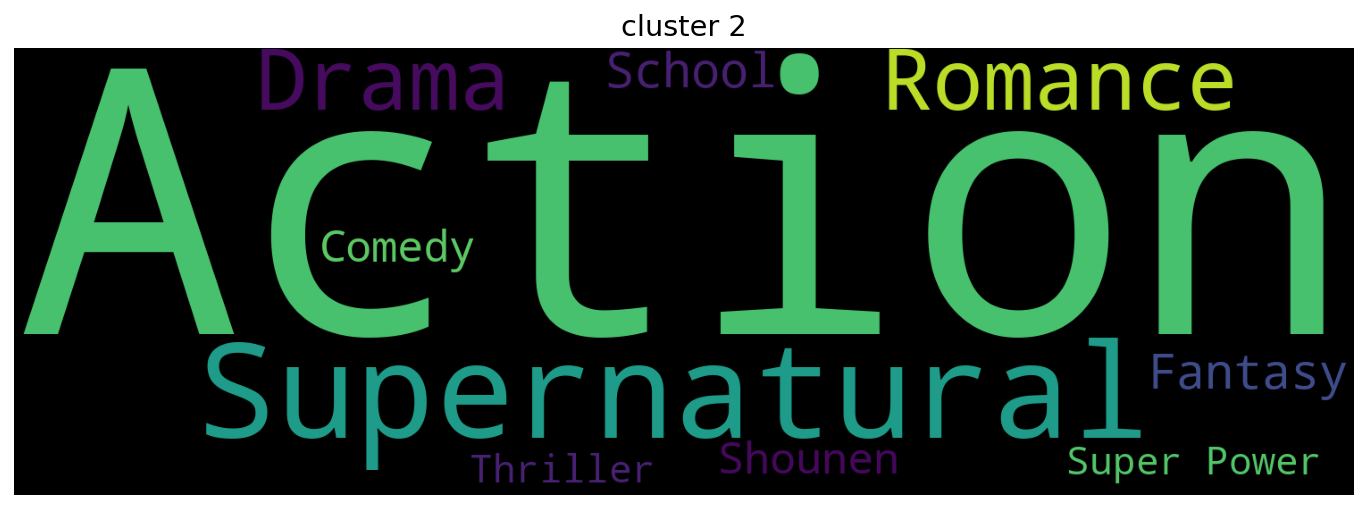

In [ ]:


c2_animelist = list(c2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 2","black")



In [ ]:


keyword_occurences[0:5]



[['Action', 7],
 [' Supernatural', 6],
 [' Drama', 6],
 [' Romance', 6],
 [' Fantasy', 5]]

In [ ]:
c2_data['episode'].mean()

24.333333333333332

In [ ]:
print('cluster 2\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c2_data['episode'].mean(), c2_data['rating'].mean(),c2_data['member'].mean()))

cluster 2
AVG episode : 24.333333333333332
AVG movie rating : 8.066666666666666
AVG member : 665432.4666666667
